In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pydae import ssa
import ipywidgets
from emt_line import emt_line_class

In [2]:
%matplotlib widget

In [3]:
line = emt_line_class()

In [4]:
line.initialize([{'v_th':400e3,'K_v':-400e3,'K_i':0.1}],100)

ssa.eval_A(line)              # method to linealized the system and to compute matrix A
eig_df=ssa.damp_report(line)  # method to create a pandas.DataFrame after computing eigenvalues for A
eig_df

,Real,Imag,Freq.,Damp
Mode 1,-7.231329e+03,3.255772e+07,5.181722e+06,0.000222
Mode 2,-7.231329e+03,-3.255772e+07,5.181722e+06,0.000222
Mode 3,-7.347692e+03,3.260145e+07,5.188682e+06,0.000225
Mode 4,-7.347692e+03,-3.260145e+07,5.188682e+06,0.000225
Mode 5,-7.016918e+03,3.264315e+07,5.195319e+06,0.000215
...,...,...,...,...
Mode 397,-6.687245e+04,-1.261176e+07,2.007223e+06,0.005302
Mode 398,-4.679105e+04,1.833340e+07,2.917851e+06,0.002552
Mode 399,-4.679105e+04,-1.833340e+07,2.917851e+06,0.002552
Mode 400,3.043915e+01,0.000000e+00,0.000000e+00,-1.000000


### Parámetros en común

In [5]:
R_l_m = 0.0268e-3  # resistencia de la linea Ω/m
X_l_m = 0.2766e-3  # reactancia de la linea Ω/m
L_m = X_l_m/(2*np.pi*50)
C_m = 4.159e-9     # capacidad shunt de la linea F/m

Long = 200.0
N_pos = 200
Δpos = Long/N_pos
L = L_m*Δpos
C = C_m*Δpos
R_l = R_l_m*Δpos
R_s = 200000

C_speed = 1/np.sqrt(L*C) # velocidad de propagación
print(f'Velocidad de propagación = {C_speed/1000:0.1f} km/s')
R_c = np.sqrt(L/C)
print(f'Impedancia = {R_c:0.2f} Ω')

line = emt_line_class()

params_dict_base = {}
for it in range(N_pos):
    idn = f'{it}'.zfill(3)
    params_dict_base.update({f'R_{idn}':R_l})
    params_dict_base.update({f'L_{idn}':L})
    params_dict_base.update({f'C_{idn}':C})
    params_dict_base.update({f'R_s_{idn}':R_s})
    
params_dict_base.update({'Dt':0.1e-6,'di_000':0.0,'decimation':1,'R_s_000':R_c*9,'v_th':371e3,'K_v':-1000e3,'K_i':0.01})
line.initialize([params_dict_base],100)
print(f"V = {line.get_value('v_s_000')/1000:0.1f} kV")

Velocidad de propagación = 16525.5 km/s
Impedancia = 14.55 Ω
V = 325.0 kV


### Linea terminada en circuito abierto

In [12]:
line = emt_line_class()

params_dict = params_dict_base.copy()
params_dict.update({'Dt':0.1e-6,'di_000':0.0,'L_199':100})
line.initialize([params_dict],100)
t_fin = 50e-6
line.run([{'t_end': 1e-6}])
line.run([{'t_end': 2e-6,'di_000':   1e6*10e3}])
line.run([{'t_end': 7e-6+0.5e-6,'di_000':-0.2e6*10e3}])
line.run([{'t_end':t_fin,'di_000': 0.0e6}])
line.post();

np.savez('open_circuit_end.npz', t=line.T, X=line.struct[0].X)

In [13]:
plt.ioff()
plt.clf()

fig, axes = plt.subplots(nrows=1,ncols=1, figsize=(6, 3), dpi=100)

data = np.load('open_circuit_end.npz')

V_s = data['X'][:,0:-1:2]
axes.plot(range(N_pos),V_s[0,:]/1e3,'r')

line_plot = axes.plot(range(N_pos),V_s[0,:]/1e3)
#axes.legend()
axes.set_xlabel('Posición (m)')
fig.tight_layout()

axes.set_ylim((300,550))
axes.set_xlim((0,200))

axes.grid(True)

fig.tight_layout()

sld_T  = ipywidgets.FloatSlider(orientation='horizontal',description = "Time $(\mu s)$", 
                                value=0, min=0,max= t_fin*1e6, 
                                step=0.1,continuous_update=False)

def update(change):
    
    t = sld_T.value   
    it = np.searchsorted(line.T[:,0], t*1e-6)
    line_plot[0].set_data(range(N_pos),V_s[it,:]/1e3)
    fig.canvas.draw_idle()
      
sld_T.observe(update, names='value')

layout_row1 = ipywidgets.HBox([fig.canvas])
layout_row2 = ipywidgets.HBox([sld_T])

layout = ipywidgets.VBox([layout_row1,layout_row2])
layout

### Linea terminada en corto circuito

In [95]:
line = emt_line_class()

params_dict = params_dict_base.copy()
params_dict.update({'Dt':0.1e-6,'di_000':0.0,'R_s_199':0.001,'K_v':-1000e3,'K_i':0.01})
line.initialize([params_dict],100)
t_fin = 50e-6
line.run([{'t_end': 1e-6}])
line.run([{'t_end': 2e-6,'di_000':   1e6*10e3}])
line.run([{'t_end': 7e-6+0.5e-6,'di_000':-0.2e6*10e3}])
line.run([{'t_end':t_fin,'di_000': 0.0e6}])
line.post();

plt.ioff()
plt.clf()

fig, axes = plt.subplots(nrows=1,ncols=1, figsize=(6, 3), dpi=100)

V_s = line.struct[0].X[:,0:-1:2]
axes.plot(range(N_pos),V_s[0,:]/1e3,'r')
line_plot = axes.plot(range(N_pos),V_s[0,:]/1e3)
#axes.legend()
axes.set_xlabel('Posición (m)')
fig.tight_layout()

axes.set_ylim((-100,100))
axes.set_xlim((0,200))

axes.grid(True)

fig.tight_layout()

sld_T  = ipywidgets.FloatSlider(orientation='horizontal',description = "Time $(\mu s)$", 
                                value=0, min=0,max= t_fin*1e6, 
                                step=1,continuous_update=False)

def update(change):
    
    t = sld_T.value 
    it = np.searchsorted(line.T[:,0], t*1e-6)
    line_plot[0].set_data(range(N_pos),V_s[it,:]/1e3)
    fig.canvas.draw_idle()
      
sld_T.observe(update, names='value')

layout_row1 = ipywidgets.HBox([fig.canvas])
layout_row2 = ipywidgets.HBox([sld_T])

layout = ipywidgets.VBox([layout_row1,layout_row2])
layout


### Linea con cambio de impedancia (aumento en la mitad)

In [96]:
line = emt_line_class()

params_dict = params_dict_base.copy()
params_dict.update({'Dt':0.1e-6,'di_000':0.0})
for it in range(100,N_pos):
    idn = f'{it}'.zfill(3)
    params_dict.update({f'R_{idn}':2*R_l})
    params_dict.update({f'L_{idn}':2*L})

line.initialize([params_dict],100)
t_fin = 50e-6
line.run([{'t_end': 1e-6}])
line.run([{'t_end': 2e-6,'di_000':   1e6*10e3}])
line.run([{'t_end': 7e-6+0.1e-6,'di_000':-0.2e6*10e3}])
line.run([{'t_end':t_fin,'di_000': 0.0e6}])
line.post();

plt.ioff()
plt.clf()

fig, axes = plt.subplots(nrows=1,ncols=1, figsize=(6, 3), dpi=100)

V_s = line.struct[0].X[:,0:-1:2]
line_plot = axes.plot(range(N_pos),V_s[0,:]/1e3)
#axes.legend()
axes.set_xlabel('Posición (m)')
fig.tight_layout()

axes.set_ylim((300,450))
axes.set_xlim((0,200))

axes.grid(True)

fig.tight_layout()

sld_T  = ipywidgets.FloatSlider(orientation='horizontal',description = "Time $(\mu s)$", 
                                value=0, min=0,max= t_fin*1e6, 
                                step=1,continuous_update=False)

def update(change):
    
    t = sld_T.value
    
    it = np.searchsorted(line.T[:,0], t*1e-6)
    
    line_plot[0].set_data(range(N_pos),V_s[it,:]/1e3)

    fig.canvas.draw_idle()
      
sld_T.observe(update, names='value')

layout_row1 = ipywidgets.HBox([fig.canvas])
layout_row2 = ipywidgets.HBox([sld_T])

layout = ipywidgets.VBox([layout_row1,layout_row2])
layout

### Linea con cambio de impedancia (disminución en la mitad)

In [97]:
line = emt_line_class()

params_dict = params_dict_base.copy()
params_dict.update({'Dt':0.1e-6,'di_000':0.0})
for it in range(100,N_pos):
    idn = f'{it}'.zfill(3)
    params_dict.update({f'R_{idn}':0.5*R_l})
    params_dict.update({f'L_{idn}':0.5*L})

line.initialize([params_dict],100)
t_fin = 50e-6
line.run([{'t_end': 1e-6}])
line.run([{'t_end': 2e-6,'di_000':   1e6*10e3}])
line.run([{'t_end': 7e-6+0.5e-6,'di_000':-0.2e6*10e3}])
line.run([{'t_end':t_fin,'di_000': 0.0e6}])
line.post();

plt.ioff()
plt.clf()

fig, axes = plt.subplots(nrows=1,ncols=1, figsize=(6, 3), dpi=100)

V_s = line.struct[0].X[:,0:-1:2]
axes.plot(range(N_pos),V_s[0,:]/1e3,'r')
line_plot = axes.plot(range(N_pos),V_s[0,:]/1e3)
#axes.legend()
axes.set_xlabel('Posición (m)')
fig.tight_layout()

axes.set_ylim((200,500))
axes.set_xlim((0,200))

axes.grid(True)

fig.tight_layout()

sld_T  = ipywidgets.FloatSlider(orientation='horizontal',description = "Time $(\mu s)$", 
                                value=0, min=0,max= t_fin*1e6, 
                                step=1,continuous_update=False)

def update(change):
    
    t = sld_T.value    
    it = np.searchsorted(line.T[:,0], t*1e-6)
    line_plot[0].set_data(range(N_pos),V_s[it,:]/1e3)
    fig.canvas.draw_idle()
      
sld_T.observe(update, names='value')

layout_row1 = ipywidgets.HBox([fig.canvas])
layout_row2 = ipywidgets.HBox([sld_T])

layout = ipywidgets.VBox([layout_row1,layout_row2])
layout

### Linea con descargador (50 m)

In [98]:
line = emt_line_class()

params_dict = params_dict_base.copy()
params_dict.update({'Dt':0.1e-6,'di_000':0.0,'L_150':100,'K_v':-400e3,'K_i':0.01})

line.initialize([params_dict],100)
t_fin = 50e-6
line.run([{'t_end': 1e-6}])
line.run([{'t_end': 2e-6,'di_000':   1e6*10e3}])
line.run([{'t_end': 7e-6+0.5e-6,'di_000':-0.2e6*10e3}])
line.run([{'t_end':t_fin,'di_000': 0.0e6}])
line.post();

plt.ioff()
plt.clf()

fig, axes = plt.subplots(nrows=1,ncols=1, figsize=(6, 3), dpi=100)

V_s = line.struct[0].X[:,0:-1:2]
axes.plot(range(N_pos),V_s[0,:]/1e3,'r')
line_plot = axes.plot(range(N_pos),V_s[0,:]/1e3)
#axes.legend()
axes.set_xlabel('Posición (m)')
fig.tight_layout()

axes.set_ylim((200,500))
axes.set_xlim((0,200))

axes.grid(True)

fig.tight_layout()

sld_T  = ipywidgets.FloatSlider(orientation='horizontal',description = "Time $(\mu s)$", 
                                value=0, min=0,max= t_fin*1e6, 
                                step=1,continuous_update=False)

def update(change):
    
    t = sld_T.value    
    it = np.searchsorted(line.T[:,0], t*1e-6)
    line_plot[0].set_data(range(N_pos),V_s[it,:]/1e3)
    fig.canvas.draw_idle()
      
sld_T.observe(update, names='value')

layout_row1 = ipywidgets.HBox([fig.canvas])
layout_row2 = ipywidgets.HBox([sld_T])

layout = ipywidgets.VBox([layout_row1,layout_row2])
layout

### Linea con descargador (5 m)

In [99]:
line = emt_line_class()

params_dict = params_dict_base.copy()
params_dict.update({'Dt':0.1e-6,'di_000':0.0,'L_105':100,'K_v':-400e3,'K_i':0.01})

line.initialize([params_dict],100)
t_fin = 50e-6
line.run([{'t_end': 1e-6}])
line.run([{'t_end': 2e-6,'di_000':   1e6*10e3}])
line.run([{'t_end': 7e-6+0.5e-6,'di_000':-0.2e6*10e3}])
line.run([{'t_end':t_fin,'di_000': 0.0e6}])
line.post();

plt.ioff()
plt.clf()

fig, axes = plt.subplots(nrows=1,ncols=1, figsize=(6, 3), dpi=100)

V_s = line.struct[0].X[:,0:-1:2]
axes.plot(range(N_pos),V_s[0,:]/1e3,'r')
line_plot = axes.plot(range(N_pos),V_s[0,:]/1e3)
#axes.legend()
axes.set_xlabel('Posición (m)')
fig.tight_layout()

axes.set_ylim((200,500))
axes.set_xlim((0,200))

axes.grid(True)

fig.tight_layout()

sld_T  = ipywidgets.FloatSlider(orientation='horizontal',description = "Time $(\mu s)$", 
                                value=0, min=0,max= t_fin*1e6, 
                                step=0.1,continuous_update=False)

def update(change):
    
    t = sld_T.value    
    it = np.searchsorted(line.T[:,0], t*1e-6)
    line_plot[0].set_data(range(N_pos),V_s[it,:]/1e3)
    fig.canvas.draw_idle()
      
sld_T.observe(update, names='value')

layout_row1 = ipywidgets.HBox([fig.canvas])
layout_row2 = ipywidgets.HBox([sld_T])

layout = ipywidgets.VBox([layout_row1,layout_row2])
layout

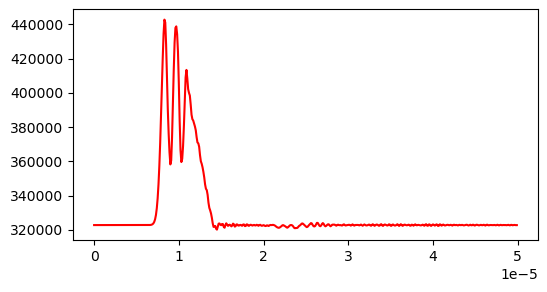

In [103]:
fig, axes = plt.subplots(nrows=1,ncols=1, figsize=(6, 3), dpi=100)

axes.plot(line.T,line.get_values('v_s_105'),'r')
fig

In [113]:
with open(r'https://github.com/jmmauricio/e-dashboards/blob/c48ee5665be1b2d43b80a6177ab2519bb62ef5e2/data/open_circuit_end.csv', 'r') as f:
    T = np.load(f)

OSError: [Errno 22] Invalid argument: 'https://github.com/jmmauricio/e-dashboards/blob/c48ee5665be1b2d43b80a6177ab2519bb62ef5e2/data/open_circuit_end.csv'

In [116]:
open(r'https://raw.githubusercontent.com/jmmauricio/e-dashboards/c48ee5665be1b2d43b80a6177ab2519bb62ef5e2/data/open_circuit_end.csv', 'r')

OSError: [Errno 22] Invalid argument: 'https://raw.githubusercontent.com/jmmauricio/e-dashboards/c48ee5665be1b2d43b80a6177ab2519bb62ef5e2/data/open_circuit_end.csv'

In [ ]:
line = emt_line_class()

times = np.arange(0,60e-6,0.1e-6)
Dt = times[1]

N_pos = 200
params_dict = {}
for it in range(N_pos):
    idn = f'{it}'.zfill(3)
    params_dict.update({f'R_s_{idn}':100000})
    params_dict.update({f'R_{idn}':0.001})

for it in range(100):
    idn = f'{it}'.zfill(3)
    params_dict.update({f'L_{idn}':L*10})
    
    
params = params_dict
params.update({'Dt':0.1e-6,'di_000':0.0,'decimation':1,'R_s_000':R_c})
line.initialize([params])

t_fin = 50e-6
line.run([{'t_end': 1e-6}])
line.run([{'t_end': 2e-6,'di_000':   1e6}])
line.run([{'t_end': 7e-6,'di_000':-0.2e6}])
line.run([{'t_end':t_fin,'di_000': 0.0e6}])

line.post();